<center><h1>DSCI 552 Machine Learning for Data Science HW5</h1></center>
<br>
<center> <font size="4">Name:Chung Ming Wu</font></center>

<center> USC_ID:7703568593</center>
    
<center> Github_Username:andywu96 </center>

## 1. Decision Trees as Interpretable Models
### 1-(a)  Download the Accute Inflamations data from https://archive.ics.uci.edu/ ml/datasets/Acute+Inflammations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read dataframe
df1 = pd.read_csv('../data/diagnosis.data', header = None, encoding = 'utf-16', sep = '\t', 
                  names = ['a1','a2','a3','a4','a5','a6','d1','d2'])

In [3]:
df1

,a1,a2,a3,a4,a5,a6,d1,d2
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,"41,4",no,yes,yes,no,yes,no,yes
116,"41,5",no,no,no,no,no,no,no
117,"41,5",yes,yes,no,yes,no,no,yes
118,"41,5",no,yes,yes,no,yes,no,yes


### 1-(b) Build a decision tree on the whole data set and plot it.

This data set is a multi-label data set. Sk-Learn seems to support building multi-label decision trees. Alternatively, you can use the label powerset method to convert it to a multiclass data set. Also, you can use the binary relevance method and build one decision tree for each label. It seems that the label powerset approach is more relevant here. Is that right?

In [4]:
# from skmultilearn.problem_transform import LabelPowerset
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.problem_transform import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score
import pydotplus
from IPython.display import Image

In [5]:
df2 = df1.copy()
df2['a1'] = df2['a1'].str.replace(',','.')
X = df2[['a1','a2','a3','a4','a5','a6']].copy()
Y = df2[['d1','d2']]
X = X.replace('no',0)
X = X.replace('yes',1)
Y = Y.replace('no',0)
Y = Y.replace('yes',1)
X['a1'] = X['a1'].astype(float)

In [6]:
# Define a function for LabelPowerset used
def build_new_column(df):
    new_class = []
    
    for i in range(len(df)):
        if df['d1'][i] == 0 and df['d2'][i] == 0:
            new_class.append(0)
        elif df['d1'][i] == 1 and df['d2'][i] == 0:
            new_class.append(1)
        elif df['d1'][i] == 0 and df['d2'][i] == 1:
            new_class.append(2)    
        elif df['d1'][i] == 1 and df['d2'][i] == 1:   
            new_class.append(3)
            
    return new_class

new_class1 = build_new_column(Y)
new_class1

Y['new_class'] = new_class1
Y = Y.drop(columns=['d1', 'd2'])
Y

,new_class
0,0
1,1
2,0
3,1
4,0
...,...
115,2
116,0
117,2
118,2


In [7]:
# rename columns
col_names = ['Temperature of patient','Occurrence of nausea',
             'Lumbar pain','Urine pushing','Micturition pains',
             'Burning of urethra, itch, swelling of urethra outlet'] 

In [8]:
# using Label Powerset
classifier =  DecisionTreeClassifier(criterion='gini',random_state = 0)

# fit a model
classifier.fit(X.values, Y.values)

#predict
predictions = classifier.predict(X.values)

#Accuracy Score
print("Accuracy = ",accuracy_score(Y.values, predictions))

Accuracy =  1.0


In [9]:
dotfile = open("classifier.dot", 'w')
tree.export_graphviz(classifier, out_file=dotfile, feature_names=col_names)
dotfile.close()

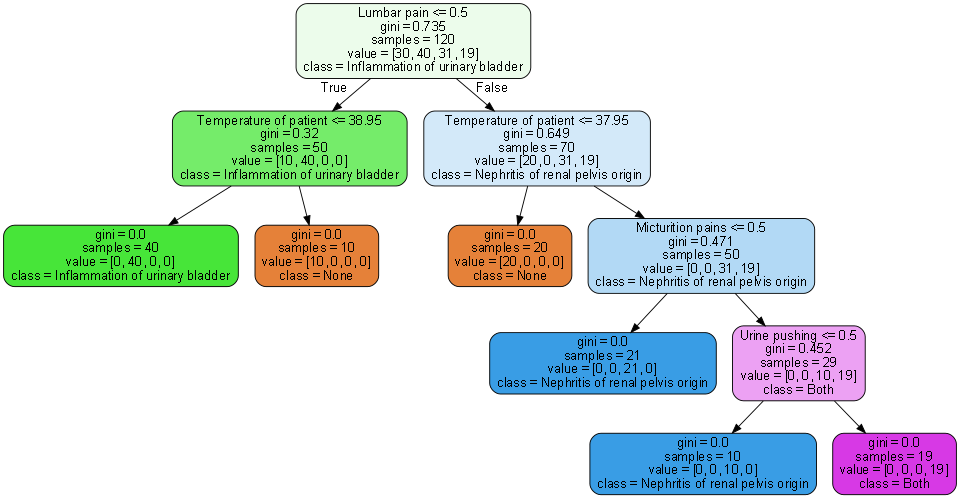

In [10]:
#plot the tree
dot_data = export_graphviz(classifier,
                            feature_names=col_names,
                            class_names = ['None','Inflammation of urinary bladder',
                                         'Nephritis of renal pelvis origin','Both'],
                            out_file=None,filled=True,
                           rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tree.png');
pydot_graph.set_size('"10,10!"')
Image(pydot_graph.create_png())

**In this case, label powerset approach is more relevant, because it can help to differentiate the patient whether is suffer from Nephritis of renal pelvis origin or Inflammation of urinary bladder. So, we transform the problem into a multi-class problem with one multi-class classifier is trained on all unique label combinations found in the training data.**

### 1-(c) Convert the decision rules into a set of IF-THEN rules.

In [11]:
def tree_to_pseudo(tree, feature_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print (indent,"} ELSE {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print (indent,"}")
        else:
            print (indent,"return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [12]:
print(tree_to_pseudo(classifier, col_names))

 if ( Lumbar pain <= 0.5 ) {
   if ( Temperature of patient <= 38.95000076293945 ) {
     return [[ 0. 40.  0.  0.]]
   } ELSE {
     return [[10.  0.  0.  0.]]
   }
 } ELSE {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[20.  0.  0.  0.]]
   } ELSE {
     if ( Micturition pains <= 0.5 ) {
       return [[ 0.  0. 21.  0.]]
     } ELSE {
       if ( Urine pushing <= 0.5 ) {
         return [[ 0.  0. 10.  0.]]
       } ELSE {
         return [[ 0.  0.  0. 19.]]
       }
     }
   }
 }
None


### 1-(d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)

In [14]:
path = classifier.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']
alphas

array([0.        , 0.10901163, 0.11824324, 0.1838129 , 0.22189108])

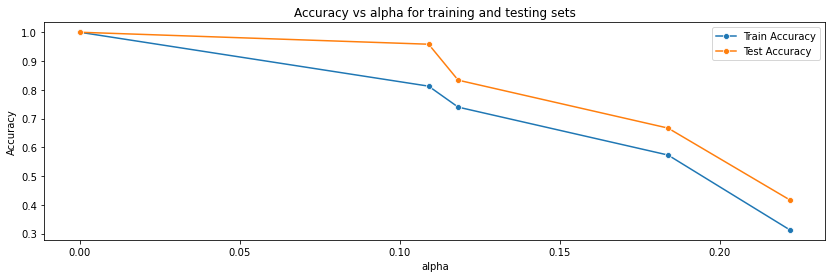

In [15]:
accuracy_train = []
accuracy_test  = [] 

for i in alphas:
    tree2 =  DecisionTreeClassifier(ccp_alpha = i)
    tree2.fit(X_train, y_train)
    
    prediction_train = tree2.predict(X_train)
    prediction_test = tree2.predict(X_test)
    
    accuracy_train.append(accuracy_score(y_train, prediction_train))
    accuracy_test.append(accuracy_score(y_test, prediction_test))
    
plt.figure(figsize= (14,4))
sns.lineplot(y=accuracy_train, x = alphas, label= "Train Accuracy",marker="o")
sns.lineplot(y=accuracy_test, x = alphas, label= "Test Accuracy",marker="o")
plt.xlabel("alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.show()

In [16]:
tree3 =  DecisionTreeClassifier(ccp_alpha = 0)
tree3.fit(X_train, y_train)
tree3.get_depth()

4

**The minimal decision tree depth is 4**

**The best ccp_alpha is 0**

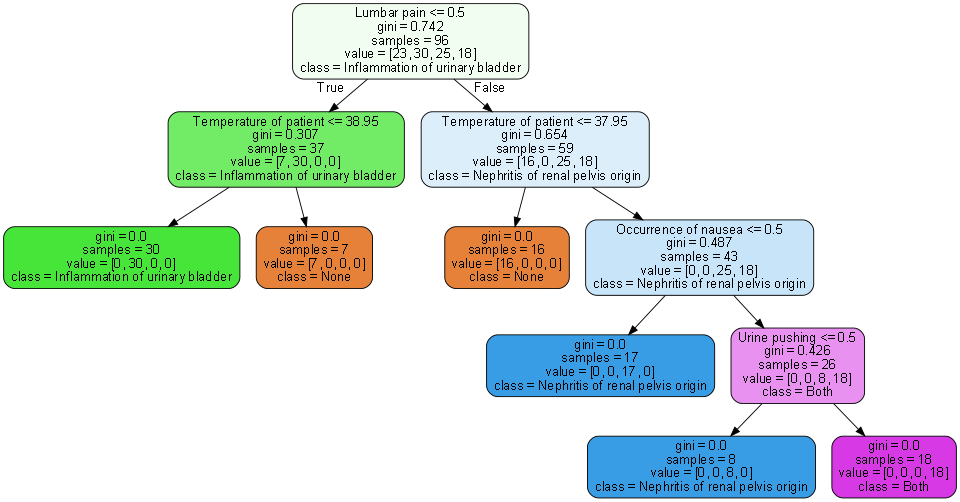

In [17]:
#plot the tree
dot_data = export_graphviz(tree3,
                            feature_names=col_names,
                            class_names = ['None','Inflammation of urinary bladder',
                                         'Nephritis of renal pelvis origin','Both'],
                            out_file=None,filled=True,
                           rounded=True)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10,10!"')
pydot_graph.write_png('tree.png');
Image(pydot_graph.create_png())

## 2. The LASSO and Boosting for Regression

### 2-(a) Download the Communities and Crime data3 from https://archive.ics.uci. edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set

### 2-(b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [18]:
# load dataset
df3 = pd.read_csv('../data/communities.data', header = None,  sep = ',', names = ['state',
                                                                        'county','community','communityname','fold','population','householdsize','racepctblack','racePctWhite','racePctAsian','racePctHisp','agePct12t21','agePct12t29','agePct16t24','agePct65up','numbUrban','pctUrban','medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap','HispPerCap','NumUnderPov','PctPopUnderPov','PctLess9thGrade','PctNotHSGrad','PctBSorMore','PctUnemployed','PctEmploy','PctEmplManu','PctEmplProfServ','PctOccupManu','PctOccupMgmtProf','MalePctDivorce','MalePctNevMarr','FemalePctDiv','TotalPctDiv','PersPerFam','PctFam2Par','PctKids2Par','PctYoungKids2Par','PctTeen2Par','PctWorkMomYoungKids','PctWorkMom','NumIlleg','PctIlleg','NumImmig','PctImmigRecent','PctImmigRec5','PctImmigRec8','PctImmigRec10','PctRecentImmig','PctRecImmig5','PctRecImmig8','PctRecImmig10','PctSpeakEnglOnly','PctNotSpeakEnglWell','PctLargHouseFam','PctLargHouseOccup','PersPerOccupHous','PersPerOwnOccHous','PersPerRentOccHous','PctPersOwnOccup','PctPersDenseHous','PctHousLess3BR','MedNumBR','HousVacant','PctHousOccup','PctHousOwnOcc','PctVacantBoarded','PctVacMore6Mos','MedYrHousBuilt','PctHousNoPhone','PctWOFullPlumb','OwnOccLowQuart','OwnOccMedVal','OwnOccHiQuart','RentLowQ','RentMedian','RentHighQ','MedRent','MedRentPctHousInc','MedOwnCostPctInc','MedOwnCostPctIncNoMtg','NumInShelters','NumStreet','PctForeignBorn','PctBornSameState','PctSameHouse85','PctSameCity85','PctSameState85','LemasSwornFT','LemasSwFTPerPop','LemasSwFTFieldOps','LemasSwFTFieldPerPop','LemasTotalReq','LemasTotReqPerPop','PolicReqPerOffic','PolicPerPop','RacialMatchCommPol','PctPolicWhite','PctPolicBlack','PctPolicHisp','PctPolicAsian','PctPolicMinor','OfficAssgnDrugUnits','NumKindsDrugsSeiz','PolicAveOTWorked','LandArea','PopDens','PctUsePubTrans','PolicCars','PolicOperBudg','LemasPctPolicOnPatr','LemasGangUnitDeploy','LemasPctOfficDrugUn','PolicBudgPerPop','ViolentCrimesPerPop'])

In [19]:
df3 = df3.replace('?', np.nan)

In [20]:
df3

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [21]:
# loop through the columns and check the missing values

for col in df3.columns:
    pct_missing = df3[col].isnull().mean()
    print(f'{col} - {pct_missing :.1%}')

state - 0.0%
county - 58.9%
community - 59.0%
communityname - 0.0%
fold - 0.0%
population - 0.0%
householdsize - 0.0%
racepctblack - 0.0%
racePctWhite - 0.0%
racePctAsian - 0.0%
racePctHisp - 0.0%
agePct12t21 - 0.0%
agePct12t29 - 0.0%
agePct16t24 - 0.0%
agePct65up - 0.0%
numbUrban - 0.0%
pctUrban - 0.0%
medIncome - 0.0%
pctWWage - 0.0%
pctWFarmSelf - 0.0%
pctWInvInc - 0.0%
pctWSocSec - 0.0%
pctWPubAsst - 0.0%
pctWRetire - 0.0%
medFamInc - 0.0%
perCapInc - 0.0%
whitePerCap - 0.0%
blackPerCap - 0.0%
indianPerCap - 0.0%
AsianPerCap - 0.0%
OtherPerCap - 0.1%
HispPerCap - 0.0%
NumUnderPov - 0.0%
PctPopUnderPov - 0.0%
PctLess9thGrade - 0.0%
PctNotHSGrad - 0.0%
PctBSorMore - 0.0%
PctUnemployed - 0.0%
PctEmploy - 0.0%
PctEmplManu - 0.0%
PctEmplProfServ - 0.0%
PctOccupManu - 0.0%
PctOccupMgmtProf - 0.0%
MalePctDivorce - 0.0%
MalePctNevMarr - 0.0%
FemalePctDiv - 0.0%
TotalPctDiv - 0.0%
PersPerFam - 0.0%
PctFam2Par - 0.0%
PctKids2Par - 0.0%
PctYoungKids2Par - 0.0%
PctTeen2Par - 0.0%
PctWorkMomYou

**I found some of the columns have more than 80% of missing value, but I still deceide to keep all features. Because, as per intuition, if we remove the feature, the model will not be able to learn from that feature if there is a high for relation of that feature with others.**

In [22]:
# we found lots of columns need to be numeric but are object
df3.dtypes

state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr     object
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop         object
ViolentCrimesPerPop    float64
Length: 128, dtype: object

In [23]:
# drop nonpredictive features
df4 = df3.copy()
df4 = df4.drop(['state','county','community','communityname','fold'], axis=1)

# convert all columns into numeric
df4 = df4.apply(pd.to_numeric)
df4.dtypes

population             float64
householdsize          float64
racepctblack           float64
racePctWhite           float64
racePctAsian           float64
                        ...   
LemasPctPolicOnPatr    float64
LemasGangUnitDeploy    float64
LemasPctOfficDrugUn    float64
PolicBudgPerPop        float64
ViolentCrimesPerPop    float64
Length: 123, dtype: object

In [24]:
# separate into train set and test set
train_set = df4.iloc[:1495,]
test_set = df4.iloc[1495:,]

In [25]:
# using train_set' mean to fill up with missing value for test_set
train_set = train_set.fillna(train_set.mean())
test_set = test_set.fillna(train_set.mean())

In [26]:
train_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [27]:
test_set

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1496,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
1497,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1498,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
1499,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


In [28]:
df5 = pd.concat([train_set, test_set],axis = 0)
df5

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### 2-(c) Plot a correlation matrix for the features in the data set.

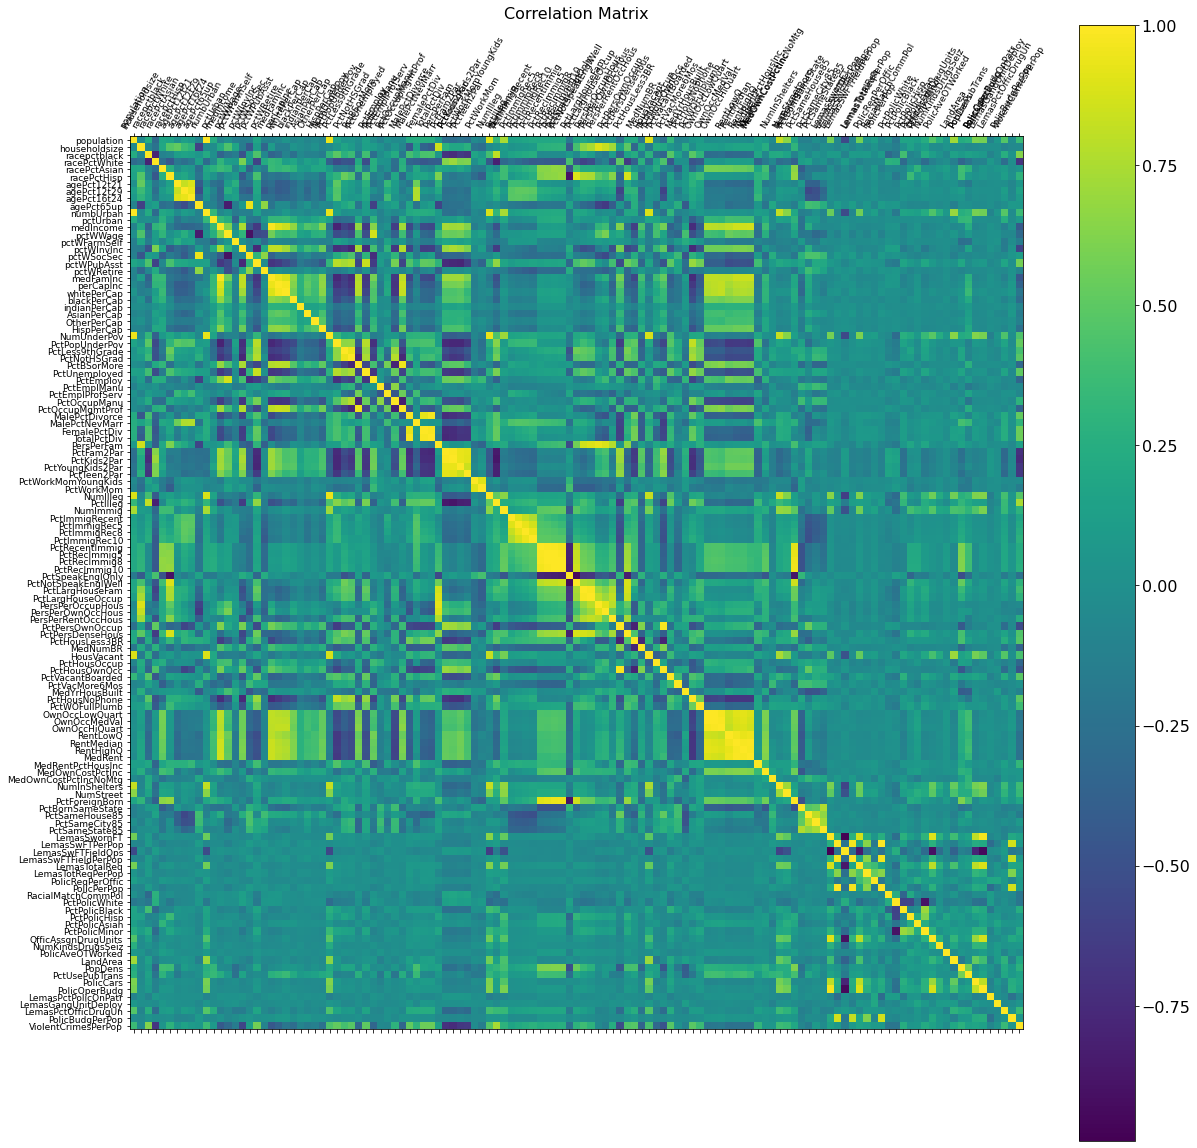

In [29]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20, 20))
plt.matshow(df5.corr(),fignum=f.number)
plt.xticks(range(df5.select_dtypes(['number']).shape[1]), df5.columns, fontsize=9, rotation=60)
plt.yticks(range(df5.select_dtypes(['number']).shape[1]), df5.columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title('Correlation Matrix', fontsize=16);

### 2-(d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [30]:
npa = df5.values
cv =  lambda x: np.std(x) / np.mean(x)
var = np.apply_along_axis(cv, axis=0, arr=npa)
var

array([2.20294993, 0.3532097 , 1.41056656, 0.32370036, 1.35882134,
       1.61387296, 0.36574812, 0.29061999, 0.49503634, 0.42333552,
       2.00124163, 0.63868866, 0.579608  , 0.32762787, 0.69985456,
       0.35914986, 0.36842021, 0.6988552 , 0.3495514 , 0.52759954,
       0.54549659, 0.5074249 , 0.58932117, 0.80948203, 0.60604183,
       0.67047988, 0.47384086, 2.30439167, 0.75379109, 0.67543079,
       0.52815378, 0.57825579, 0.55599333, 0.34724014, 0.5104523 ,
       0.39812581, 0.5083338 , 0.422     , 0.39548416, 0.40371035,
       0.3591826 , 0.371375  , 0.31687526, 0.33052823, 0.3323925 ,
       0.32934323, 0.32846855, 0.33616412, 0.33263868, 2.99344555,
       0.91957222, 2.89976977, 0.6840295 , 0.58474358, 0.50478324,
       0.45555177, 1.29977426, 1.29730638, 1.28091166, 1.28371176,
       0.28860078, 1.45870069, 0.73435052, 0.75691886, 0.36682182,
       0.31932719, 0.46833631, 0.3502283 , 1.1269169 , 0.34828327,
       0.81068443, 1.9582885 , 0.26957935, 0.33745632, 1.06447

In [31]:
cols=df5.columns.values
colvars=pd.DataFrame(np.column_stack([cols, var]))
colvars = colvars.rename(columns={0: 'Columns_name', 1: 'Coefficient of Variation CV'})
colvars

,Columns_name,Coefficient of Variation CV
0,population,2.20295
1,householdsize,0.35321
2,racepctblack,1.41057
3,racePctWhite,0.3237
4,racePctAsian,1.35882
...,...,...
118,LemasPctPolicOnPatr,0.120441
119,LemasGangUnitDeploy,0.360209
120,LemasPctOfficDrugUn,2.55463
121,PolicBudgPerPop,0.343695


### 2-(e) Pick [$\sqrt[2]{128}$] features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [32]:
import math 

# get the features
sorte = colvars.sort_values('Coefficient of Variation CV', ascending=False)
highestvar= sorte.head(int(math.floor(math.sqrt(128))))

In [33]:
# Result of 11 highest CV features 
print(highestvar)

            Columns_name Coefficient of Variation CV
90             NumStreet                      4.4066
89         NumInShelters                     3.48461
49              NumIlleg                     2.99345
51              NumImmig                     2.89977
120  LemasPctOfficDrugUn                     2.55463
27           NumUnderPov                     2.30439
0             population                     2.20295
10             numbUrban                     2.00124
71            HousVacant                     1.95829
113             LandArea                     1.67761
5            racePctHisp                     1.61387


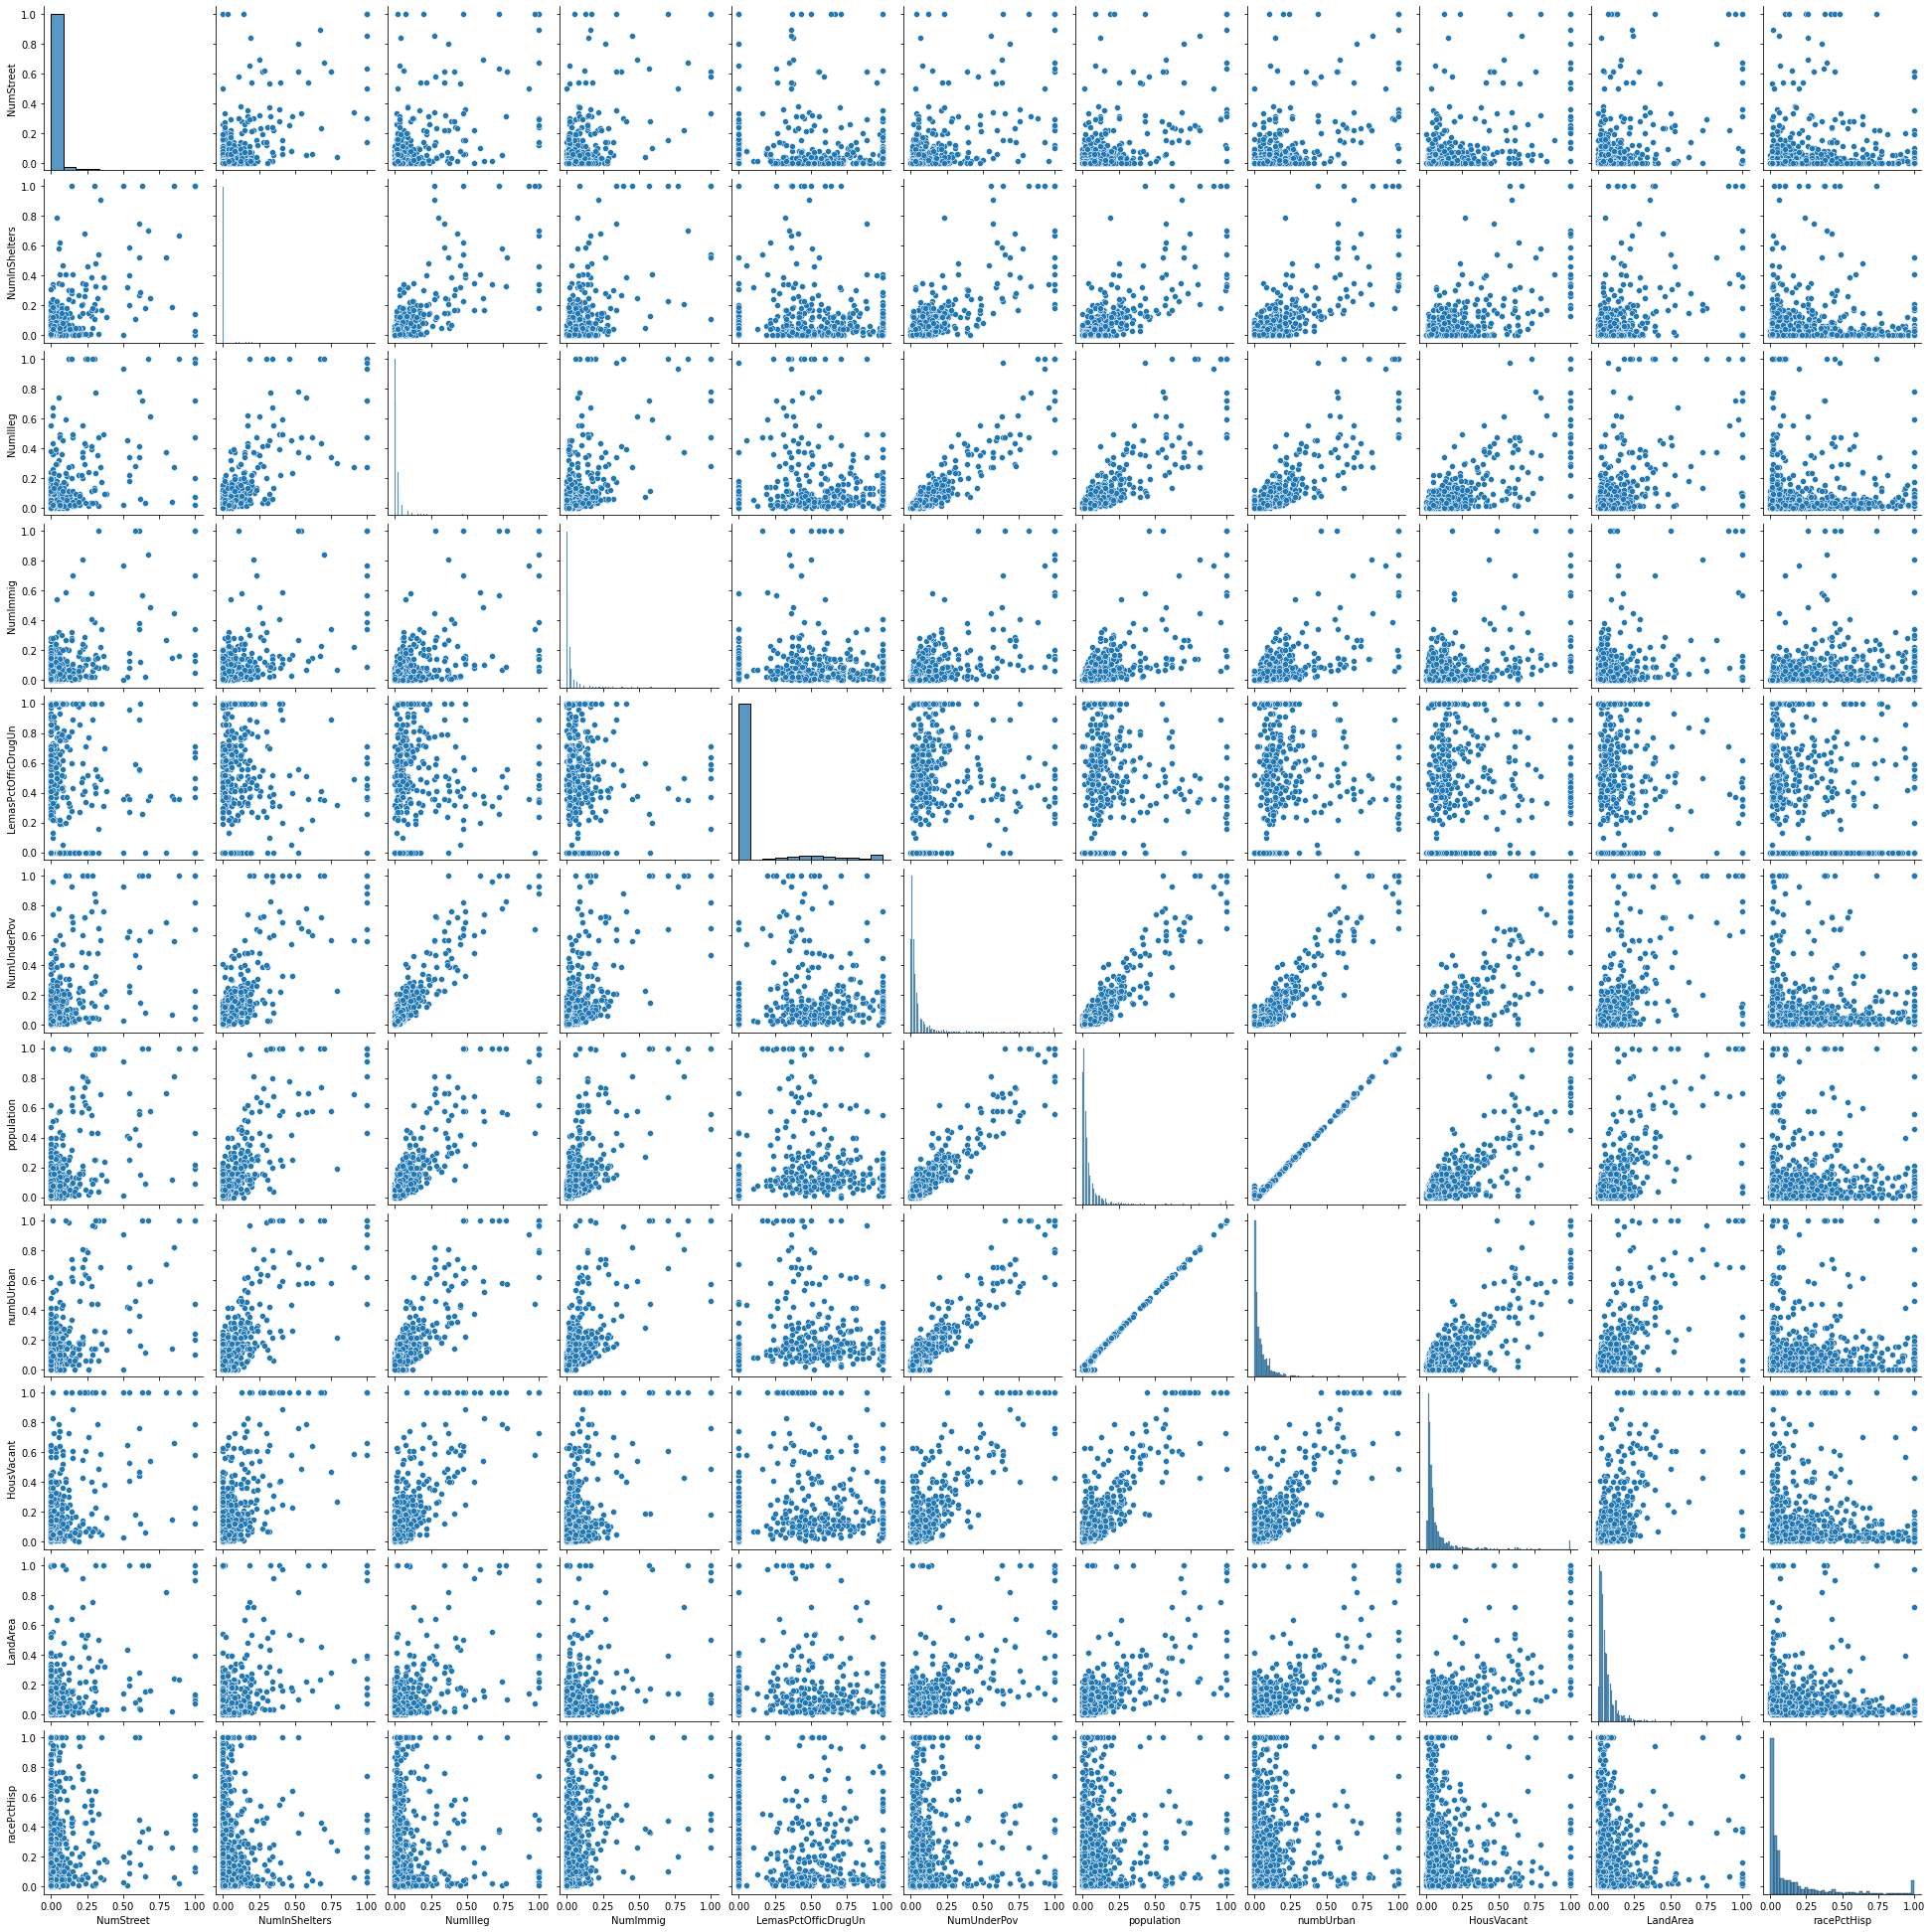

In [34]:
# draw 11 pairwise scatter plot
import seaborn as sns

selected_cols = df5[highestvar['Columns_name']]
sns.pairplot(selected_cols)

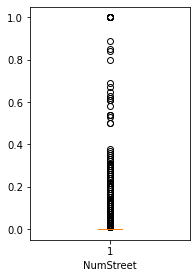

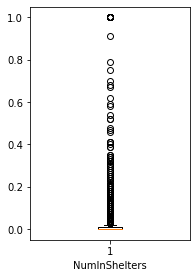

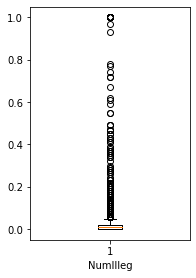

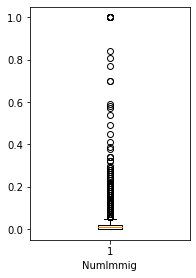

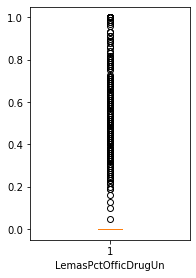

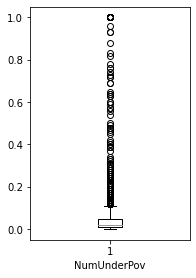

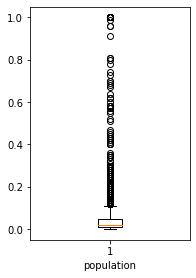

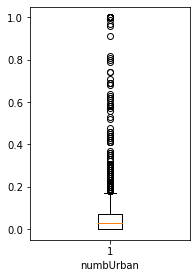

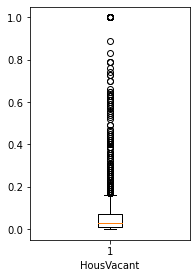

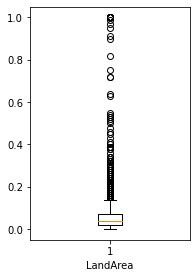

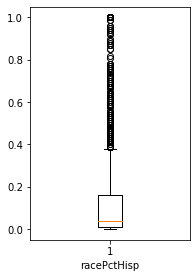

In [35]:
# draw box plot 

box = selected_cols.columns
i=1
for k in box:
    plt.subplots(figsize=(20, 30))
    plt.subplot(6,6,i)
    plt.xlabel(k)
    plt.boxplot(selected_cols[k])
    i=i+1

**No, we can just find the relatinoship between two features on scatter plots, and if we want to define the significance of those features, need to fit a model and using p-value to decide.**

### 2-(f) Fit a linear model using least squares to the training set and report the test error.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train_set_X = df5.iloc[:1495,:122]
test_set_X = df5.iloc[1495:,:122]
train_set_y =  df5.iloc[:1495,122]
test_set_y  =  df5.iloc[1495:,122]

# fit a train model 
model1 = LinearRegression()
model1 = model1.fit(train_set_X, train_set_y )
yhat1 = model1.predict(train_set_X)
trainerror1 = mean_squared_error(train_set_y,yhat1)

print("Train Error of Linear Regression",trainerror1)

Train Error of Linear Regression 0.01631022814395748


In [37]:
# fit a test set to find test error
yhat2 = model1.predict(test_set_X)
testerror1 = mean_squared_error(test_set_y,yhat2)

print("Test Error of Linear Regression",testerror1)

Test Error of Linear Regression 5.22821468103502e+17


**Training error is small and test error is big is an indication of overfitting. Usually we can reduce the complexity of model to address this. Other thing that we can do is to provide more data if possible.**

### 2-(g) Fit a ridge regression model on the training set, with lambda chosen by cross-validation. Report the test error obtained.

In [38]:
from sklearn.linear_model import RidgeCV

# Ridge regression with Cross-validation
Ridge_model = RidgeCV(alphas=[0.0001, 0.001 ,0.01, 0.05, 1, 10, 100], alpha_per_target=True )
Ridge_model.fit(train_set_X, train_set_y)

# get the best lambda

print("Lambda having minimum error", Ridge_model.alpha_)

Lambda having minimum error 1.0


In [39]:
# find the test Error
prediction_y= Ridge_model.predict(test_set_X)
print("Test Error of Ridge Regression", mean_squared_error(test_set_y,prediction_y))

Test Error of Ridge Regression 0.017732474992896492


### 2-(h)  Fit a LASSO model on the training set, with lambda chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

#### Lasso without standardized features 

In [40]:
from sklearn.preprocessing import scale
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# LASSO regression Without standardized Features 
Lasso_model_1 = LassoCV(cv=5, random_state= 0 ,tol=0.001)
Lasso_model_1.fit(train_set_X, train_set_y)

variables_1 = Lasso_model_1.coef_
prediction_lasso_1 = Lasso_model_1.predict(test_set_X)
Lasso_MSE_1 = mean_squared_error(test_set_y,prediction_lasso_1)

# Report Test Error and Coeff
print("Test Error of Lasso regression ",Lasso_MSE_1)
print("The variables coefficients selected",variables_1)

Test Error of Lasso regression  0.01775257355656763
The variables coefficients selected [-0.          0.          0.27109636 -0.         -0.01530973  0.
  0.06721429 -0.26682029  0.          0.         -0.          0.04052076
  0.         -0.08081683  0.02655375 -0.09671796  0.04965686  0.03816207
 -0.10801014  0.         -0.         -0.05790601 -0.02093562 -0.03108366
  0.02905494  0.02273058  0.02393963 -0.         -0.13990627 -0.01763873
  0.          0.         -0.          0.13589868 -0.01616556  0.
  0.01109762  0.          0.11749411  0.13308513 -0.07656664 -0.
  0.         -0.         -0.19725166 -0.03752503 -0.00991862  0.
 -0.12955811 -0.0529251   0.0992385  -0.06978333 -0.         -0.
 -0.         -0.00510723 -0.          0.          0.          0.03759343
  0.         -0.07096545 -0.         -0.06357117  0.04058272 -0.
 -0.         -0.05761389  0.218387    0.05682659  0.00355083  0.12419065
 -0.0607136   0.          0.07338126 -0.05979274 -0.01568829  0.02388484
 -0.0241671

In [41]:
lasso_columnsname = train_set_X.columns.values
lasso_colvar=pd.DataFrame(np.column_stack([lasso_columnsname, variables_1]), columns = ["Columns_name","Coeff"])
filter_colvar = lasso_colvar.loc[lasso_colvar["Coeff"] != 0]
filter_colvar

,Columns_name,Coeff
2,racepctblack,0.271096
4,racePctAsian,-0.0153097
6,agePct12t21,0.0672143
7,agePct12t29,-0.26682
11,pctUrban,0.0405208
...,...,...
115,PctUsePubTrans,-0.0437213
118,LemasPctPolicOnPatr,0.0213636
119,LemasGangUnitDeploy,0.0399871
120,LemasPctOfficDrugUn,0.00202274


#### Lasso with standardized features 

In [42]:
# LASSO regression With all standardized Features 
Lasso_model_2 = LassoCV(cv=5, random_state= 0 ,tol=0.001)
Lasso_model_2.fit(scale(train_set_X), train_set_y)

variables_2 = Lasso_model_2.coef_
prediction_lasso_2 = Lasso_model_2.predict(scale(test_set_X))
Lasso_MSE_2 = mean_squared_error(test_set_y,prediction_lasso_2)

# Report Test Error and Coeff
print("Test Error of Lasso regression ",Lasso_MSE_2 )
print("The variables coefficients selected",variables_2)

Test Error of Lasso regression  0.01798788353691748
The variables coefficients selected [-0.          0.          0.06803593 -0.         -0.00090114 -0.
  0.01040307 -0.03836626  0.          0.         -0.          0.01658892
  0.         -0.0117011   0.00408251 -0.0207462   0.00907165  0.0060732
 -0.01711467  0.         -0.         -0.00867638 -0.00365756 -0.00523467
  0.0053145   0.00381015  0.00396854 -0.         -0.02619649 -0.00186076
  0.          0.         -0.          0.0211604  -0.00104577  0.
  0.         -0.          0.01909753  0.02073125 -0.00989955 -0.
  0.         -0.         -0.03980354 -0.00808953 -0.00148707  0.
 -0.02139398 -0.00420937  0.02491762 -0.0082114  -0.         -0.00017361
 -0.         -0.00047733  0.          0.          0.          0.00645076
  0.         -0.00899601 -0.         -0.00691781  0.00359241 -0.
  0.         -0.00929081  0.04042354  0.00934503  0.          0.01719012
 -0.01177668 -0.          0.0145164  -0.01012994 -0.0029014   0.00193249
 -0.

In [43]:
lasso_columnsname = train_set_X.columns.values
lasso_colvar_standard=pd.DataFrame(np.column_stack([lasso_columnsname, variables_2]), columns = ["Columns_name","Coeff"])
filter_colvar_standard = lasso_colvar_standard.loc[lasso_colvar_standard["Coeff"] != 0]
filter_colvar_standard

,Columns_name,Coeff
2,racepctblack,0.0680359
4,racePctAsian,-0.000901141
6,agePct12t21,0.0104031
7,agePct12t29,-0.0383663
11,pctUrban,0.0165889
...,...,...
114,PopDens,0.00322797
115,PctUsePubTrans,-0.00877809
116,PolicCars,0.00409242
118,LemasPctPolicOnPatr,0.00209127


**The Test Error of standardized features is 0.01798, which is slightly higher than non-standardized features, 0.01775. Besides, variables selected by standardized features model is 75 features; then, the variables selected by non-standardized features model is 73 features.** 

### 2-(i)  Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [44]:
from sklearn.decomposition import PCA

In [45]:
lasso_mse = []

for comp in range(1,123):
    pca = PCA(n_components=comp)
    X_PCA = pca.fit_transform(scale(train_set_X))
    kf = KFold(n_splits=5)
    MSE = []
    for train_ind, val_ind in kf.split(X_PCA):
        x_train, x_val = X_PCA[train_ind.tolist()], X_PCA[val_ind.tolist()]
        y_train, y_val = np.array(train_set_y)[train_ind.tolist()], np.array(train_set_y)[val_ind.tolist()]
        model = LinearRegression()
        model = model.fit(x_train,y_train)
        pred = model.predict(x_val)
        actual = y_val
        mse = mean_squared_error(actual, pred)
        MSE.append(mse)
    lasso_mse.append(np.mean(MSE))
lasso_mse

[0.033134545273873696,
 0.029392605655063048,
 0.028345047393798124,
 0.028360486415424307,
 0.026187971543970838,
 0.02627917416995971,
 0.025838346195523453,
 0.021923347374525597,
 0.02111377457989918,
 0.021035153999181464,
 0.021038813597488958,
 0.02107470197506769,
 0.020761488016867453,
 0.020792536387824506,
 0.020739394985413738,
 0.020764531460989822,
 0.02063491763429411,
 0.020405333593864195,
 0.020442069653794685,
 0.020491937092987144,
 0.020445145238598927,
 0.0203994569742378,
 0.020462428434300076,
 0.02046494152162385,
 0.020434851736870353,
 0.02041415305263306,
 0.02024526022531395,
 0.020225864618066795,
 0.02024888944142706,
 0.02014158245932067,
 0.020019446500162793,
 0.02006053933574859,
 0.020050216521605137,
 0.020090801795438866,
 0.02018229877199387,
 0.02008969708807758,
 0.020059358585003677,
 0.020053314842887977,
 0.02008851889430672,
 0.020063754289125397,
 0.020055716728631198,
 0.02000291863447549,
 0.02000723398702032,
 0.01986534747080272,
 0.019

In [46]:
df_PCR = pd.DataFrame({"Number of Principles Components": range(1,123),"MSE":lasso_mse})
df_PCR

,Number of Principles Components,MSE
0,1,0.033135
1,2,0.029393
2,3,0.028345
3,4,0.028360
4,5,0.026188
...,...,...
117,118,0.020494
118,119,0.020480
119,120,0.020527
120,121,0.020549


In [47]:
print("Number of Principles Components: ", df_PCR['Number of Principles Components'][int(df_PCR[['MSE']].idxmin())] )
print("MSE: ", min(lasso_mse))

Number of Principles Components:  95
MSE:  0.019451422015755476


### 2-(j)  In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine alpha (the regularization term) using cross-validation.

In [48]:
from xgboost import XGBRegressor
# for the following range of values 
alphas =[0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.2,1.4,1.6,1.8, 2, 3, 4, 5, 10, 20]

l1_mse = []

for l in alphas:
    kf = KFold(n_splits=5)
    MSE = []
    for train_index,val_index in kf.split(train_set_X):
        x_train, x_val = train_set_X.iloc[train_index.tolist(),:], train_set_X.iloc[val_index.tolist(),:]
        y_train, y_val = np.array(train_set_y)[train_index.tolist()], np.array(train_set_y)[val_index.tolist()]
        xgb = XGBRegressor(random_state=0,reg_alpha=l,reg_lambda = 0)  #silent=False
        xgb.fit(x_train,y_train)
        pred = xgb.predict(x_val)
        actual = y_val
        mse = mean_squared_error(actual, pred)
        MSE.append(mse)
    l1_mse.append(np.mean(MSE))

In [49]:
df_L1 = pd.DataFrame({"L1_Alpha": alphas, "MSE":l1_mse})
df_L1

,L1_Alpha,MSE
0,0.01,0.023486
1,0.05,0.023177
2,0.10,0.022606
3,0.20,0.023367
4,0.50,0.022752
5,0.75,0.021770
6,1.20,0.021441
7,1.40,0.021620
8,1.60,0.021233
9,1.80,0.021613


In [50]:
# get the smallest MSE and its L1_Lambda
index_L1 = df_L1[['MSE']].idxmin()
print("L1 regularization Lambda :", df_L1['L1_Alpha'][int(index_L1)])
print("L1 regularization MSE :", min(df_L1['MSE']))

L1 regularization Lambda : 5.0
L1 regularization MSE : 0.020534105787301308


In [51]:
# fit the best L1_Lambda with train set and use test set to get MSE
xgb = XGBRegressor(random_state=0,reg_alpha=5.0,reg_lambda = 0)
xgb.fit(train_set_X,train_set_y)
pred = xgb.predict(test_set_X)
L1_2_mse = mean_squared_error(test_set_y, pred)

In [52]:
print("L1 regularization MSE",L1_2_mse)

L1 regularization MSE 0.01766685319939519
